# Import Libraries

In [29]:
# !pip install scipy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from skimage import feature
from sklearn import neighbors


# Retrieve Dataset

In [2]:
from preprocess import retrieve_dataset, preprocess, to_np

(train_ds_raw, test_ds_raw), metadata = retrieve_dataset(should_shuffle_files=True)

train_ds = preprocess(train_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 300,
  'is_grayscale': False, 
  'is_downsample64': False,
  'is_downsample128': False, 
  'is_normalize': False,
})

test_ds = preprocess(test_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 75,
  'is_grayscale': False, 
  'is_downsample64': False, 
  'is_downsample128': False, 
  'is_normalize': False,
})

def count_class(counts, batch):
    labels = batch[1]
    for i in range(9):
        cc = tf.cast(labels == i, tf.int32)
        counts[i] += tf.reduce_sum(cc)
    return counts

initial_state = dict((i, 0) for i in range(9))
counts = train_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for train dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

initial_state = dict((i, 0) for i in range(9))
counts = test_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for test dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

ModuleNotFoundError: No module named 'preprocess'

# Extract X_train, Y_train, X_test, Y_test

In [ ]:
train_ds_numpy = to_np(train_ds)
test_ds_numpy = to_np(test_ds)

In [ ]:
X_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

X_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

# Visualize Preprocessed Dataset

Length of X_train: 7506
Length of X_test: 1947


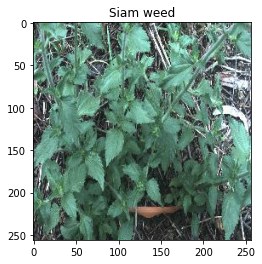

In [ ]:
from visualize import visualize, compare

visualize(X_train[0], y_train[0], metadata)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

# Perform Transfer Learning

In [ ]:
from transfer_learning import init_conv_base, extract_features
conv_base = init_conv_base(X_train[0])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
train_features, train_labels = extract_features(conv_base, X_train, y_train)  # Agree with our small dataset size
test_features, test_labels = extract_features(conv_base, X_test, y_test)

# Flatten To Feed into KNN

In [ ]:
X_train_flatten = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test_flatten = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608

(7506,)
feature size now: (256, 256, 3)


# Test Model with K Fold Validation

In [9]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import kfold_cross_validation

In [11]:
n_neighbors_arr = [5, 10, 15, 20]
metric_arr = ['euclidean', 'manhattan', 'minkowski']
k = 5
accuracies = []

for n_neighbors in n_neighbors_arr:
  accuracies.append(kfold_cross_validation(k, X_train_flatten, y_train, 'knn', {'n_neighbors': n_neighbors}))

highest_accuracy = 0
best_n = 0

for idx, val in enumerate(accuracies):
  accuracy = val
  if accuracy > highest_accuracy:
    best_n = n_neighbors_arr[idx]
    highest_accuracy = accuracy

print(f'Best n: {best_n}')

Running 5-fold cross validation for knn with {'n_neighbors': 5}
Split accuracy: 0.459387483355526
Split accuracy: 0.47168554297135246
Split accuracy: 0.45236508994004
Split accuracy: 0.4670219853431046
Split accuracy: 0.4576948700866089
Completed 5-fold cross validation for knn with {'n_neighbors': 5}
Obtained average accuracy of: 0.4616309943393264

Running 5-fold cross validation for knn with {'n_neighbors': 10}
Split accuracy: 0.46537949400798934
Split accuracy: 0.480346435709527
Split accuracy: 0.4570286475682878
Split accuracy: 0.47834776815456365
Split accuracy: 0.49700199866755496
Completed 5-fold cross validation for knn with {'n_neighbors': 10}
Obtained average accuracy of: 0.4756208688215845

Running 5-fold cross validation for knn with {'n_neighbors': 15}
Split accuracy: 0.4560585885486019
Split accuracy: 0.475016655562958
Split accuracy: 0.45569620253164556
Split accuracy: 0.4763491005996003
Split accuracy: 0.4870086608927382
Completed 5-fold cross validation for knn with {

In [12]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import get_precision_scores, get_roc_auc_curve, visualize_roc_auc_curve, train_model

In [13]:
model = train_model('knn', {'n_neighbors': n_neighbors}, X_train_flatten, y_train, True)

Saved final model to file: models/knn_n_neighbors20_final.pickle



In [14]:
print(get_precision_scores(model, X_test_flatten, y_test))

{'accuracy': 0.49614791987673346, 'macro_avg': 0.5733719929670353, 'f1_score_macro': 0.502481958667618, 'micro_avg': 0.49614791987673346, 'f1_score_micro': 0.49614791987673346, 'roc_auc_score': 0.86793412178381}


In [15]:
(fpr, tpr, roc_auc) = get_roc_auc_curve(model, X_train_flatten, y_train, X_test_flatten, y_test, {'is_svm': False})


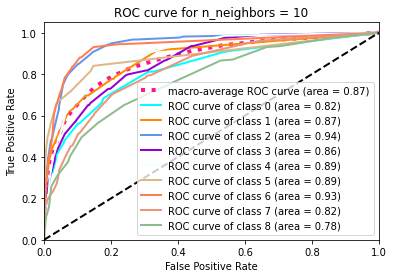

In [16]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import visualize_roc_auc_curve

title = f'ROC curve for n_neighbors = {str(best_n)}'
visualize_roc_auc_curve(title, fpr, tpr, roc_auc, len(np.unique(y_test)))